In [ ]:
from utils import *

NOTEBOOK_ID = '05'
RUN_MODELS = False

/home/lucas/anaconda3/envs/adhunter/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/lucas/anaconda3/envs/adhunter/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
Global seed set to 0


In [2]:
onehot_df = pd.read_pickle(f'{ENCODING_DIR}/01-dataset/hummel_encodings.pkl')
onehot_X = np.asarray([np.array(emb) for emb in onehot_df['onehot_encoding']])
esm_df = pd.read_pickle(f'{EMBEDDING_DIR}/01-dataset/esm2_t33_650M_UR50D-layer33-representations.pkl')
esm_X = np.asarray([np.array(emb) for emb in esm_df['esm2_t33_650M_UR50D']])
alphabet_X = np.asarray([[AA_TO_I[aa] for aa in x] for x in onehot_df['AAseq']])
esm_mean_X = np.mean(esm_X,axis=-1)
Xs = {'onehot':onehot_X,
      'onehot_flat':onehot_X.reshape(onehot_X.shape[0],onehot_X.shape[1]*onehot_X.shape[2]),
      'esm':esm_X,
      'alphabet':alphabet_X,
      'esm_mean':esm_mean_X,
      'esm_flat':esm_X.reshape(esm_X.shape[0],esm_X.shape[1]*esm_X.shape[2])}

y = esm_df['activity'].to_numpy()
thresh = esm_df['activity'].median()
y_cont = y.reshape(-1, 1)
y_cont = preprocessing.StandardScaler().fit_transform(y_cont)
y_bin = (y >= thresh).astype(np.int64).reshape(-1, 1)

In [3]:
if RUN_MODELS:
    y_test_hats = {}

    for key, X in Xs.items():
        if key in ['onehot_flat','esm_flat']:
            for state in range(1,11):
                train, val, test, idx = get_stratified_split(X, y_bin, y_cont, as_tensor=True,random_state=state)
                (X_train, y_bin_train, y_cont_train) = train
                (X_val, y_bin_val, y_cont_val) = val
                (X_test, y_bin_test, y_cont_test) = test
                (train_idx, val_idx, test_idx) = idx

                train_ds = TensorDataset(X_train.to(torch.float), y_cont_train.to(torch.float))
                train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
                val_ds = TensorDataset(X_val.to(torch.float), y_cont_val.to(torch.float))
                val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
                test_ds = TensorDataset(X_test.to(torch.float), y_cont_test.to(torch.float))

                model_name = f'NN_{key}_state{state}'
                model = NNSystem(embedding_size=(X.shape[1]),hidden=HIDDEN_SIZE)
                csv_logger = CSVLogger(f"{COMPLEX_ARCHITECTURE_DIR}/01-logs",name=model_name,version='')
                checkpoint_callback = ModelCheckpoint(dirpath=f"{COMPLEX_ARCHITECTURE_DIR}/02-models", monitor="val_loss", filename=model_name, save_last=False)
                early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
                trainer = pl.Trainer(accelerator='gpu',devices=1,callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCHS)
                trainer.fit(model,train_dataloaders=train_dl,val_dataloaders=val_dl)
                y_test_hats[('NN',key,state)] = test_model(checkpoint_callback,model,COMPLEX_ARCHITECTURE_DIR,model_name,test_ds)

In [4]:
if RUN_MODELS:
    for key, X in Xs.items():
        if key in ['esm','onehot']:
            for state in range(1,11):
                train, val, test, idx = get_stratified_split(X, y_bin, y_cont, as_tensor=True,random_state=state)
                (X_train, y_bin_train, y_cont_train) = train
                (X_val, y_bin_val, y_cont_val) = val
                (X_test, y_bin_test, y_cont_test) = test
                (train_idx, val_idx, test_idx) = idx
                train_ds = TensorDataset(X_train.to(torch.float), y_cont_train.to(torch.float))
                train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False)
                val_ds = TensorDataset(X_val.to(torch.float), y_cont_val.to(torch.float))
                val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
                test_ds = TensorDataset(X_test.to(torch.float), y_cont_test.to(torch.float))

                # CNN
                model = CNNSystem(embedding_size=X[0].shape[1],hidden_size=HIDDEN_SIZE,kernel_size=KERNEL_SIZE,seq_len=53)
                filename = f'CNN_{key}_state{state}'
                csv_logger = CSVLogger(f"{COMPLEX_ARCHITECTURE_DIR}/01-logs",name=filename,version='')
                checkpoint_callback = ModelCheckpoint(dirpath=f"{COMPLEX_ARCHITECTURE_DIR}/02-models", monitor="val_loss", filename=filename, save_last=False)
                early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
                trainer = pl.Trainer(accelerator='gpu',devices=1,callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCHS)
                trainer.fit(model,train_dataloaders=train_dl,val_dataloaders=val_dl)
                y_test_hats[('CNN',key,state)] = test_model(checkpoint_callback,model,COMPLEX_ARCHITECTURE_DIR,filename,test_ds)

                # ResNet
                model = ResNetSystem(embedding_size=X[0].shape[1],hidden_size=HIDDEN_SIZE,dilation_size=DILATION,kernel_size=KERNEL_SIZE,seq_len=53)
                filename = f'ResNet_{key}_state{state}'
                csv_logger = CSVLogger(f"{COMPLEX_ARCHITECTURE_DIR}/01-logs",name=filename,version='')
                checkpoint_callback = ModelCheckpoint(dirpath=f"{COMPLEX_ARCHITECTURE_DIR}/02-models", monitor="val_loss", filename=filename, save_last=False)
                early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
                trainer = pl.Trainer(accelerator='gpu',devices=1,callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCHS)
                trainer.fit(model,train_dataloaders=train_dl,val_dataloaders=val_dl)
                y_test_hats[('ResNet',key,state)] = test_model(checkpoint_callback,model,COMPLEX_ARCHITECTURE_DIR,filename,test_ds)

                # RNN
                model = RNNSystem(embedding_size=X[0].shape[1],hidden_size=HIDDEN_SIZE)
                filename = f'RNN_{key}_state{state}'
                csv_logger = CSVLogger(f"{COMPLEX_ARCHITECTURE_DIR}/01-logs",name=filename,version='')
                checkpoint_callback = ModelCheckpoint(dirpath=f"{COMPLEX_ARCHITECTURE_DIR}/02-models", monitor="val_loss", filename=filename, save_last=False)
                early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
                trainer = pl.Trainer(accelerator='gpu',devices=1,callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCHS)
                trainer.fit(model,train_dataloaders=train_dl,val_dataloaders=val_dl)
                y_test_hats[('RNN',key,state)] = test_model(checkpoint_callback,model,COMPLEX_ARCHITECTURE_DIR,filename,test_ds)

                # LSTM
                model = LSTMSystem(input_size=X[0].shape[1], hidden_size=HIDDEN_SIZE)
                filename = f'LSTM_{key}_state{state}'
                csv_logger = CSVLogger(f"{COMPLEX_ARCHITECTURE_DIR}/01-logs",name=filename,version='')
                checkpoint_callback = ModelCheckpoint(dirpath=f"{COMPLEX_ARCHITECTURE_DIR}/02-models", monitor="val_loss", filename=filename, save_last=False)
                early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
                trainer = pl.Trainer(accelerator='gpu',devices=1,callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCHS)
                trainer.fit(model,train_dataloaders=train_dl,val_dataloaders=val_dl)
                y_test_hats[('LSTM',key,state)] = test_model(checkpoint_callback,model,COMPLEX_ARCHITECTURE_DIR,filename,test_ds)

                # transformer
                model = TransformerSystem(embedding_dim=X[0].shape[1],
                                        transformer_nhead=1,
                                        num_encoder_layers=1,
                                        dim_feedforward=HIDDEN_SIZE)
                filename = f'Transformer_{key}_state{state}'
                csv_logger = CSVLogger(f"{COMPLEX_ARCHITECTURE_DIR}/01-logs",name=filename,version='')
                checkpoint_callback = ModelCheckpoint(dirpath=f"{COMPLEX_ARCHITECTURE_DIR}/02-models", monitor="val_loss", filename=filename, save_last=False)
                early_stopping = EarlyStopping('val_loss', patience=PATIENCE)
                trainer = pl.Trainer(accelerator='gpu',devices=1,callbacks=[checkpoint_callback, early_stopping], logger=[csv_logger], max_epochs=MAX_EPOCHS)
                trainer.fit(model,train_dataloaders=train_dl,val_dataloaders=val_dl)
                y_test_hats[('Transformer',key,state)] = test_model(checkpoint_callback,model,COMPLEX_ARCHITECTURE_DIR,filename,test_ds)

                tmp_df = pd.DataFrame([y_test_hats]).T
                tmp_df.to_pickle(f'{COMPLEX_ARCHITECTURE_DIR}/complex_model_test.pkl')

In [ ]:
test_df = pd.read_pickle(f'{COMPLEX_ARCHITECTURE_DIR}/complex_model_test.pkl').rename(columns={0:'results'})
test_df['r'] = test_df['results'].apply(lambda x: pearsonr(x[0],x[1])[0])
test_df['rmse'] = test_df['results'].apply(lambda x: mean_squared_error(x[0],x[1],squared=False)  )
test_df = test_df.reset_index()
test_df['model'] = test_df['index'].apply(lambda x: x[0])
test_df['encoding'] = test_df['index'].apply(lambda x: x[1])
test_df['state'] = test_df['index'].apply(lambda x: x[2])
test_df = test_df.drop(columns=['index','results']).query('encoding != "alphabet" and encoding != "esm_mean"')
test_df['encoding'] = test_df['encoding'].replace({'onehot_flat':'Simple','onehot':'Simple','esm_flat':'Neural','esm':'Neural'})
test_df

,r,rmse,model,encoding,state
0,0.40,0.92,NN,Simple,1
1,0.42,0.89,NN,Simple,2
2,0.43,0.91,NN,Simple,3
3,0.40,0.96,NN,Simple,4
4,0.42,0.88,NN,Simple,5
...,...,...,...,...,...
115,0.73,0.68,CNN,Neural,10
116,0.73,0.68,ResNet,Neural,10
117,0.68,0.74,RNN,Neural,10
118,0.69,0.74,LSTM,Neural,10


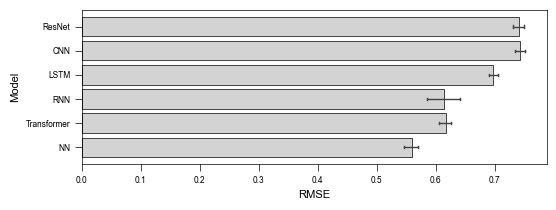

In [11]:
plt.figure(figsize=(6,2))
g = sns.barplot(data=test_df.query('model != "ResNet_v2" and encoding == "Neural"').sort_values(['r'],ascending=False),y='model',x='r',color='lightgrey',edgecolor='black',linewidth=0.5,errwidth=1,capsize=0.1,)
g.set(ymargin=0.05,xlabel='RMSE',ylabel='Model')

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-complex_models_pearson.png',dpi=400,bbox_inches='tight',transparent=False)

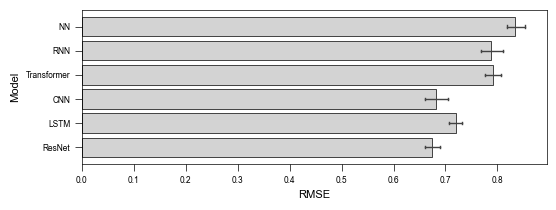

In [12]:
plt.figure(figsize=(6,2))
g = sns.barplot(data=test_df.query('model != "ResNet_v2" and encoding == "Neural"').sort_values(['rmse'],ascending=False),y='model',x='rmse',color='lightgrey',edgecolor='black',linewidth=0.5,errwidth=1,capsize=0.1,)
g.set(ymargin=0.05,xlabel='RMSE',ylabel='Model')

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-complex_models_rmse.png',dpi=400,bbox_inches='tight',transparent=False)

In [13]:
test_df.query('encoding == "Neural"').drop(columns=['encoding']).groupby(['model']).mean().sort_values('r').style

,r,rmse,state
model,,,
NN,0.558902,0.832881,5.500000
RNN,0.614076,0.788297,5.500000
Transformer,0.616624,0.790585,5.500000
LSTM,0.696737,0.719776,5.500000
ResNet,0.740526,0.674811,5.500000
CNN,0.742080,0.681160,5.500000


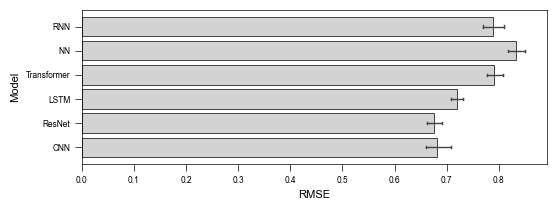

In [14]:
plt.figure(figsize=(6,2))
g = sns.barplot(data=test_df.query('model != "ResNet_v2" and encoding == "Neural"').sort_values(['r']),y='model',x='rmse',color='lightgrey',edgecolor='black',linewidth=0.5,errwidth=1,capsize=0.1,)
g.set(ymargin=0.05,xlabel='RMSE',ylabel='Model')

if SAVE_FIGURES:
    plt.savefig(f'{FIGURE_DIR}/{NOTEBOOK_ID}-complex_models.png',dpi=400,bbox_inches='tight',transparent=False)

In [17]:
test_df.query('model != "ResNet_v2" and encoding == "Neural"').drop(columns=['encoding']).groupby(['model']).median().style

,r,rmse,state
model,,,
CNN,0.737053,0.678542,5.500000
LSTM,0.695420,0.722318,5.500000
NN,0.561353,0.825670,5.500000
RNN,0.612004,0.779468,5.500000
ResNet,0.740613,0.672036,5.500000
Transformer,0.613278,0.787483,5.500000
